# Data Ingestion & Initial Inspection

In [2]:
import pandas as pd
import numpy as np
# Load the dataset
df = pd.read_csv("../data/heart.csv")
# Show first few rows
display(df.head(10))

,gender,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,Male,39.0,4.0,No,0.0,No,No,No,No,195.0,106.0,70.0,26.97,80.0,77.0,0.0
1,Female,46.0,2.0,No,0.0,No,No,No,No,250.0,121.0,81.0,28.73,95.0,76.0,0.0
2,Male,48.0,1.0,Yes,20.0,No,No,No,No,245.0,127.5,80.0,25.34,75.0,70.0,0.0
3,Female,61.0,3.0,Yes,30.0,No,No,Yes,No,225.0,150.0,95.0,28.58,65.0,103.0,1.0
4,Female,46.0,3.0,Yes,23.0,No,No,No,No,285.0,130.0,84.0,23.10,85.0,85.0,0.0
5,Female,43.0,2.0,No,0.0,No,No,Yes,No,228.0,180.0,110.0,30.30,77.0,99.0,0.0
6,Female,63.0,1.0,No,0.0,No,No,No,No,205.0,138.0,71.0,33.11,60.0,85.0,1.0
7,Female,45.0,2.0,Yes,20.0,No,No,No,No,313.0,100.0,71.0,21.68,79.0,78.0,0.0
8,Male,52.0,1.0,No,0.0,No,No,Yes,No,260.0,141.5,89.0,26.36,76.0,79.0,0.0
9,Male,43.0,1.0,Yes,30.0,No,No,Yes,No,225.0,162.0,107.0,23.61,93.0,88.0,0.0


In [3]:
# Shape (rows, columns)
print("Shape:", df.shape)

# Column names
print("Columns:", df.columns.tolist())

# Data types and non-null counts
print(df.info())

# Quick statistical summary (numeric only)
print(df.describe().T)

Shape: (11000, 16)
Columns: ['gender', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose', 'TenYearCHD']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11000 entries, 0 to 10999
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   gender           10944 non-null  object 
 1   age              10925 non-null  float64
 2   education        11000 non-null  float64
 3   currentSmoker    11000 non-null  object 
 4   cigsPerDay       10954 non-null  float64
 5   BPMeds           11000 non-null  object 
 6   prevalentStroke  11000 non-null  object 
 7   prevalentHyp     10871 non-null  object 
 8   diabetes         10783 non-null  object 
 9   totChol          10960 non-null  float64
 10  sysBP            11000 non-null  float64
 11  diaBP            10588 non-null  float64
 12  BMI              1093

In [4]:
# Count missing values per column
print(df.isnull().sum())

# Percentage missing
print((df.isnull().sum() / len(df)) * 100)

# Check duplicates
print("Duplicate rows:", df.duplicated().sum())

gender              56
age                 75
education            0
currentSmoker        0
cigsPerDay          46
BPMeds               0
prevalentStroke      0
prevalentHyp       129
diabetes           217
totChol             40
sysBP                0
diaBP              412
BMI                 65
heartRate           48
glucose              0
TenYearCHD         361
dtype: int64
gender             0.509091
age                0.681818
education          0.000000
currentSmoker      0.000000
cigsPerDay         0.418182
BPMeds             0.000000
prevalentStroke    0.000000
prevalentHyp       1.172727
diabetes           1.972727
totChol            0.363636
sysBP              0.000000
diaBP              3.745455
BMI                0.590909
heartRate          0.436364
glucose            0.000000
TenYearCHD         3.281818
dtype: float64
Duplicate rows: 0


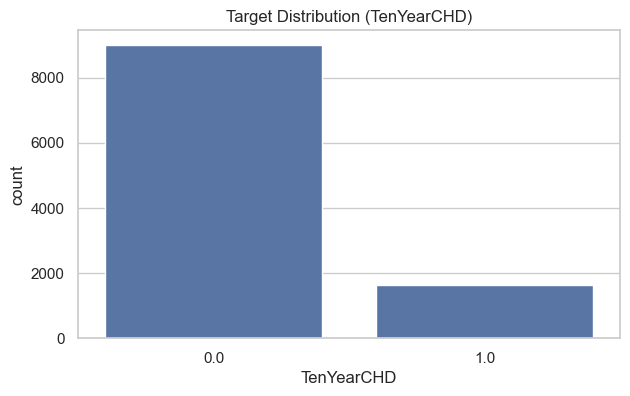

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x="TenYearCHD", data=df)
plt.title("Target Distribution (TenYearCHD)")
plt.show()

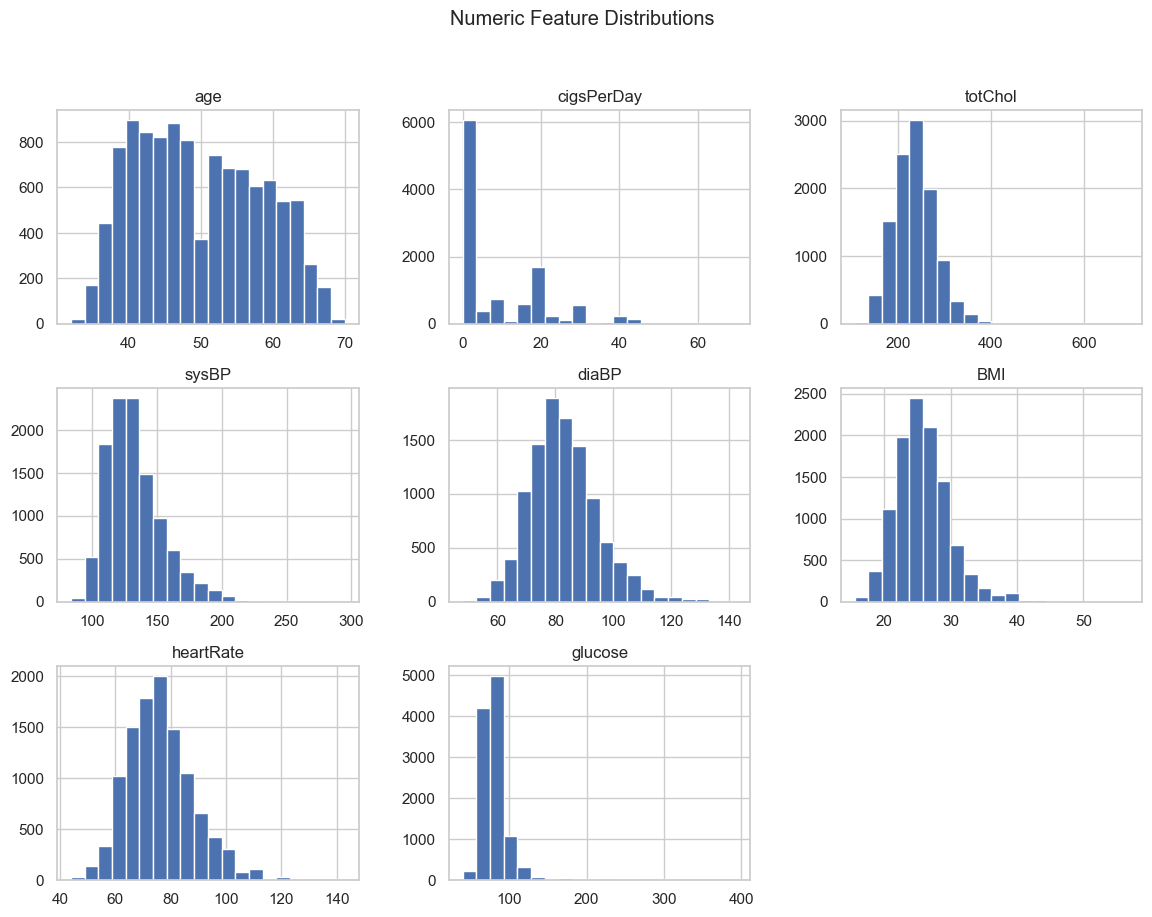

In [90]:
numeric_cols = ['age','cigsPerDay','totChol','sysBP','diaBP','BMI','heartRate','glucose']

df[numeric_cols].hist(figsize=(14,10), bins=20)
plt.suptitle("Numeric Feature Distributions")
plt.show()

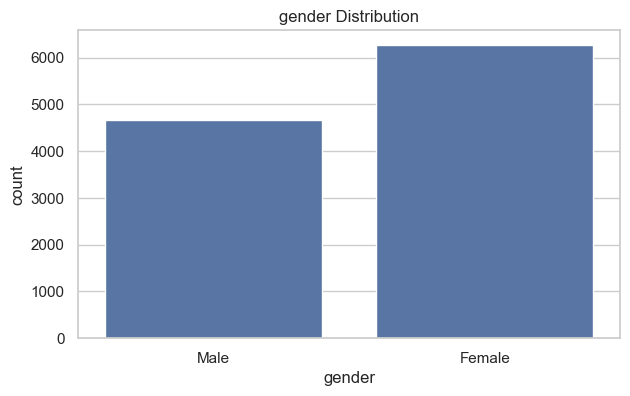

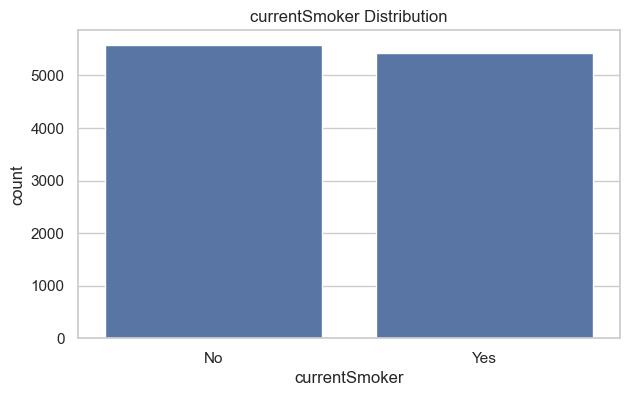

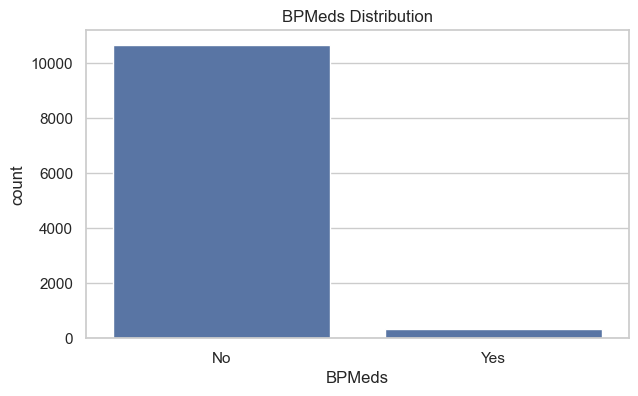

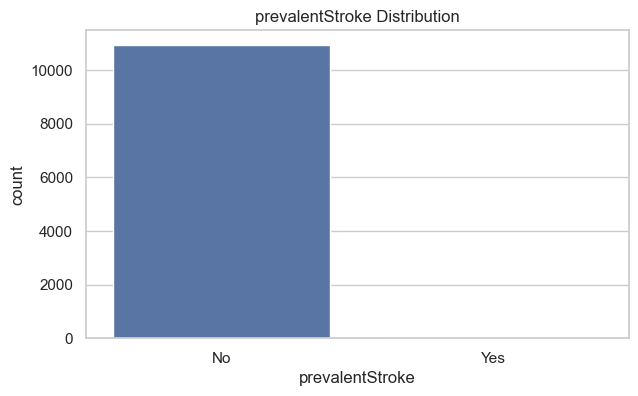

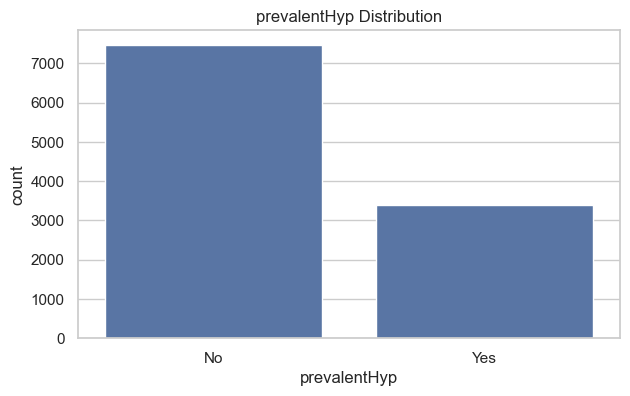

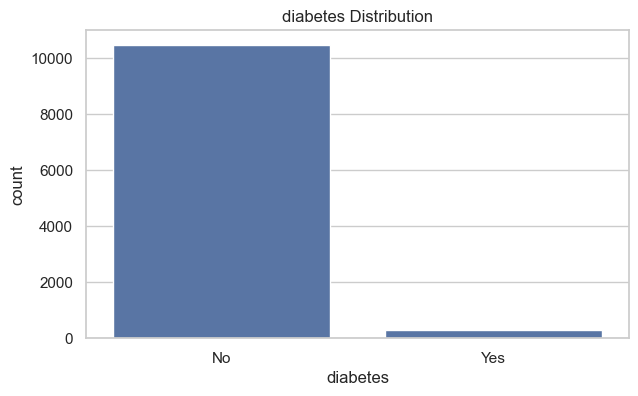

In [91]:
categorical_cols = ['gender','currentSmoker','BPMeds','prevalentStroke','prevalentHyp','diabetes']

for col in categorical_cols:
    sns.countplot(x=col, data=df)
    plt.title(f"{col} Distribution")
    plt.show()

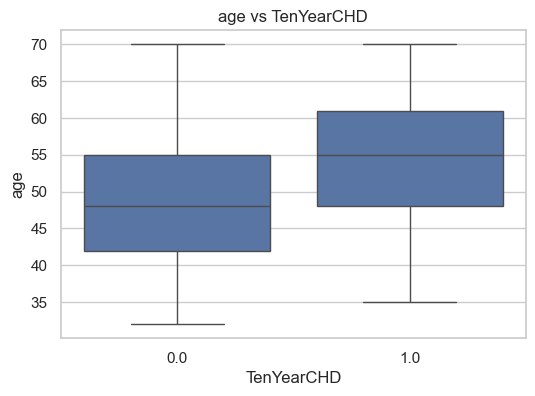

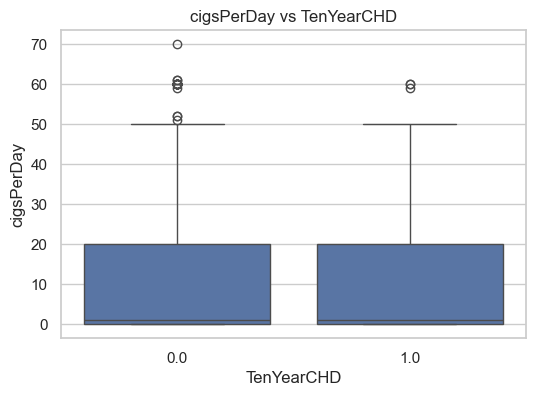

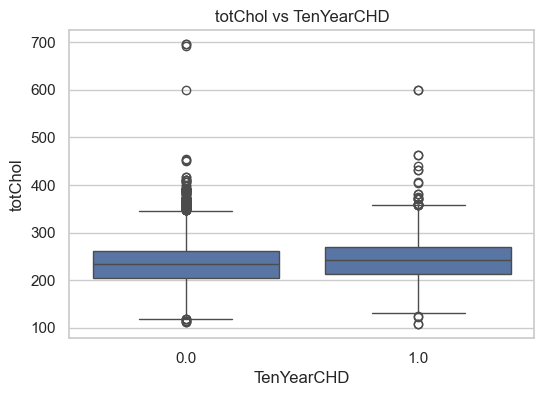

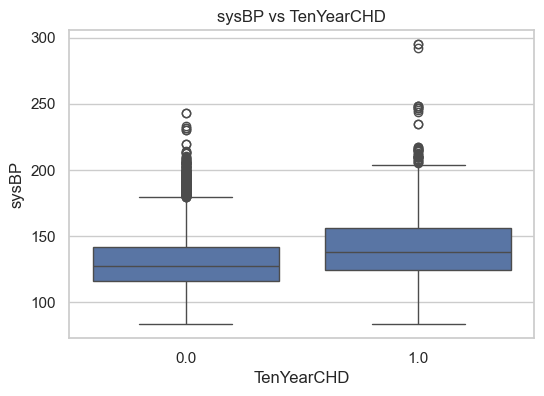

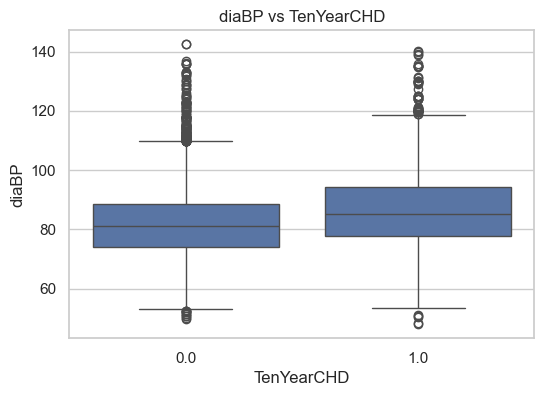

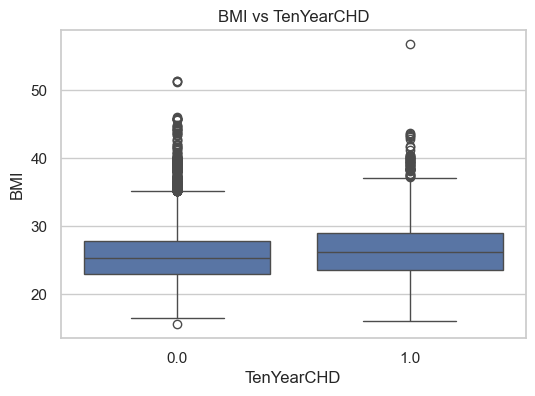

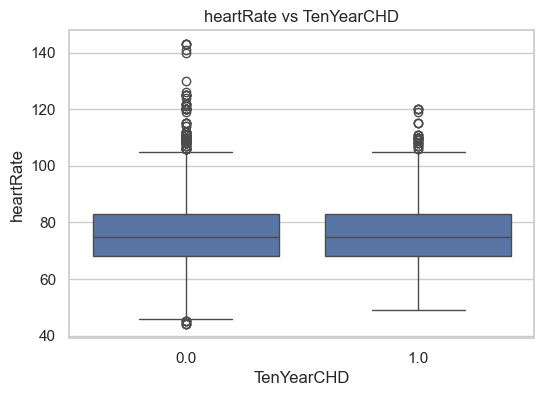

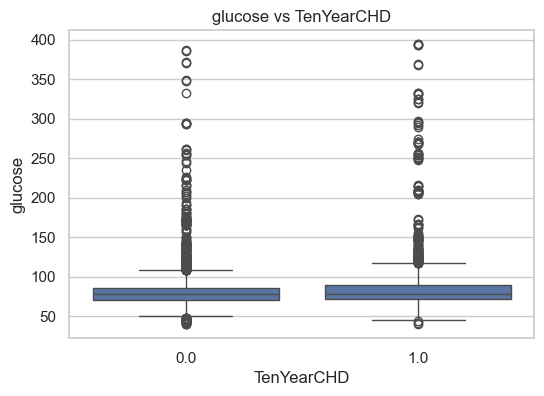

In [92]:
for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x="TenYearCHD", y=col, data=df)
    plt.title(f"{col} vs TenYearCHD")
    plt.show()

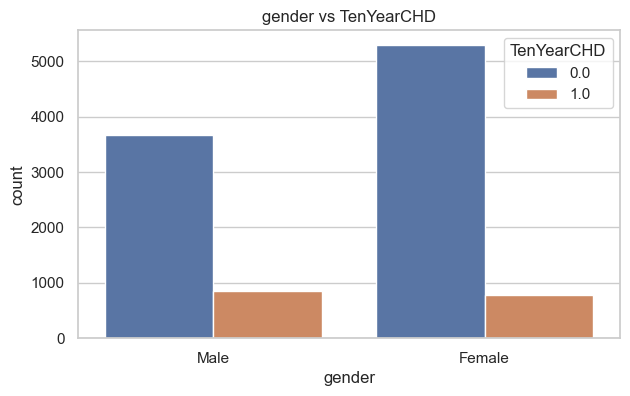

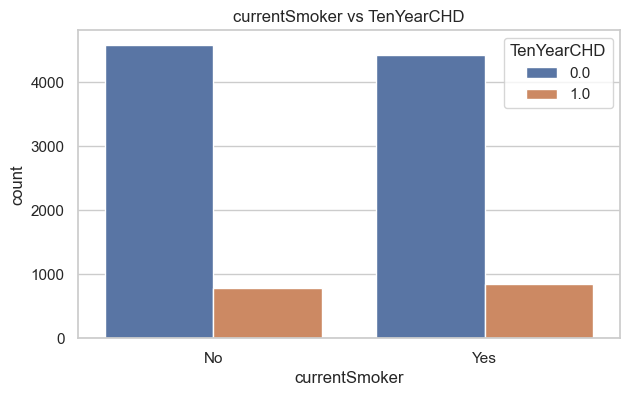

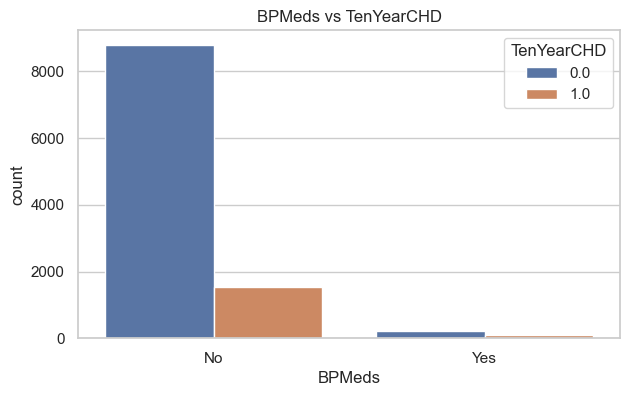

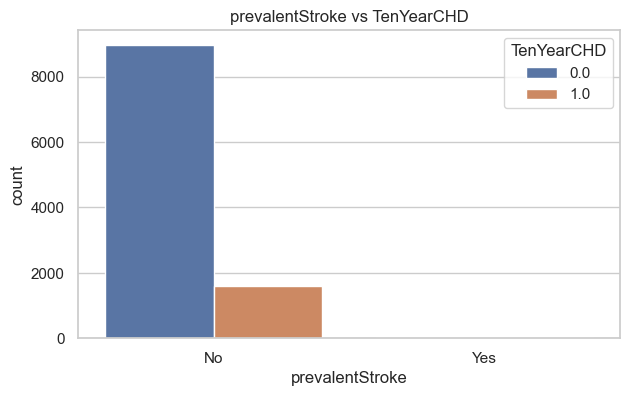

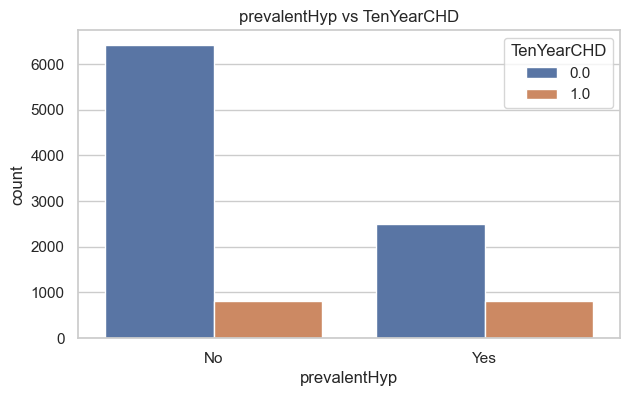

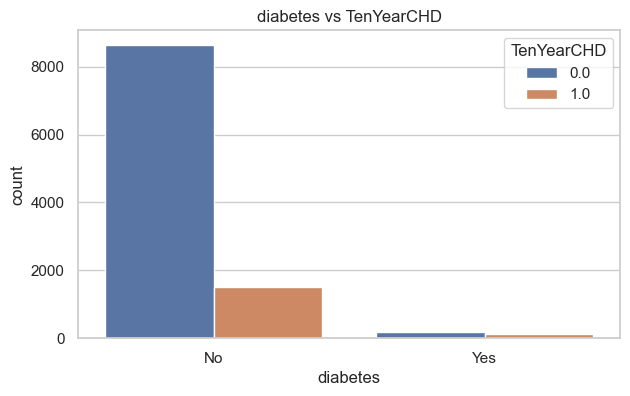

In [93]:
for col in categorical_cols:
    sns.countplot(x=col, hue="TenYearCHD", data=df)
    plt.title(f"{col} vs TenYearCHD")
    plt.show()

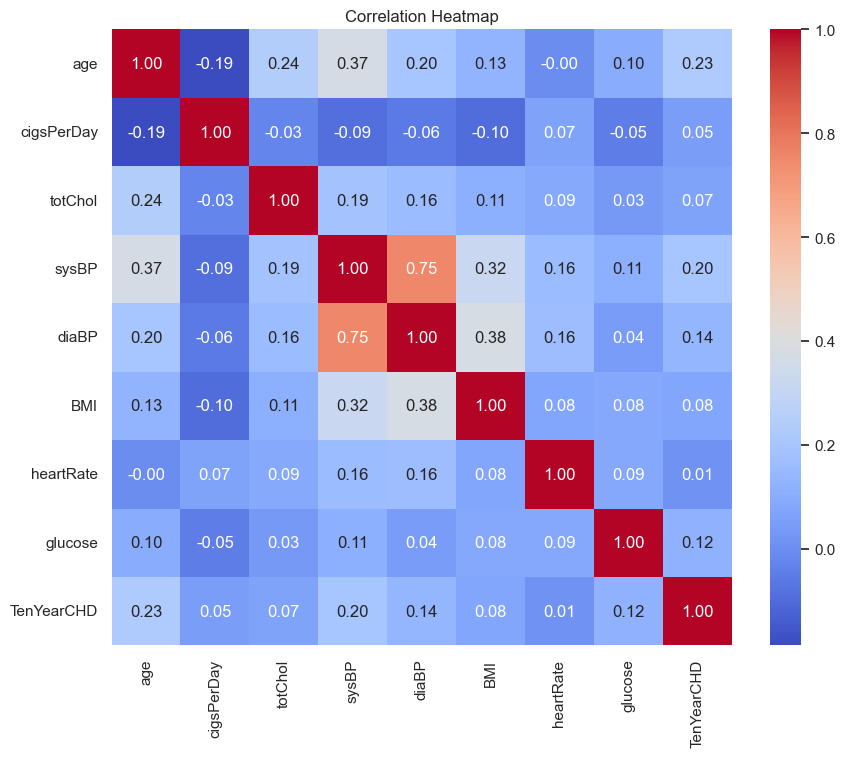

In [94]:
plt.figure(figsize=(10,8))
sns.heatmap(df[numeric_cols + ['TenYearCHD']].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

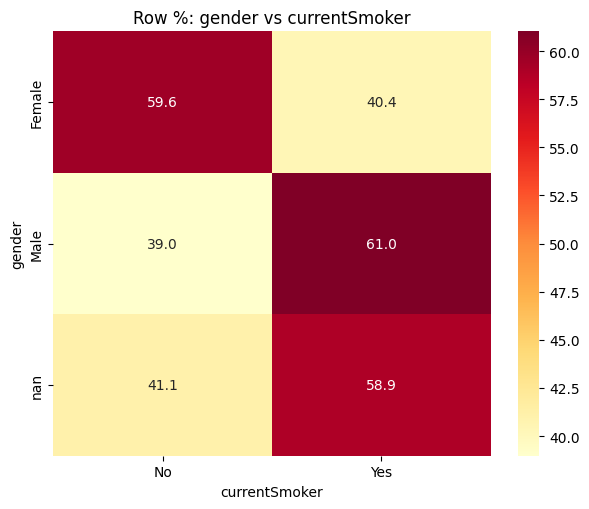

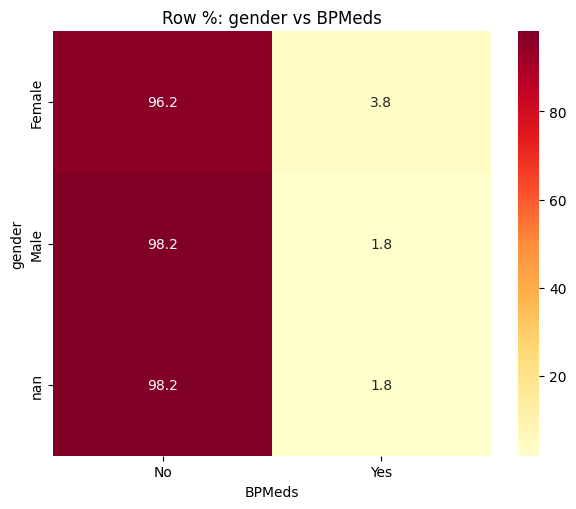

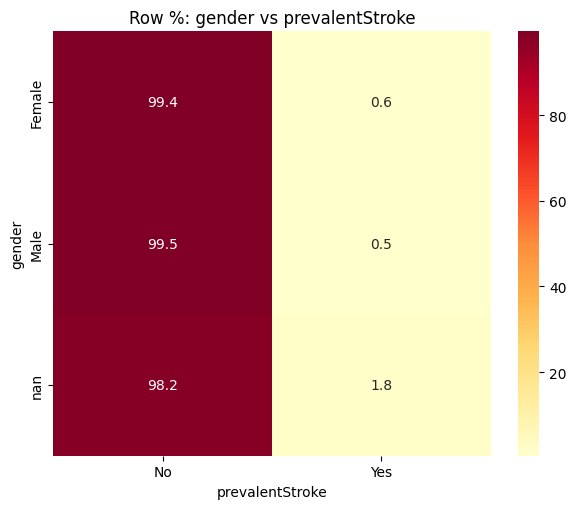

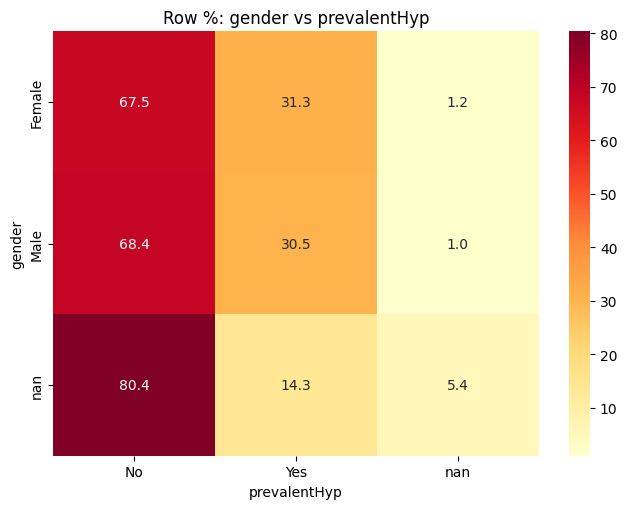

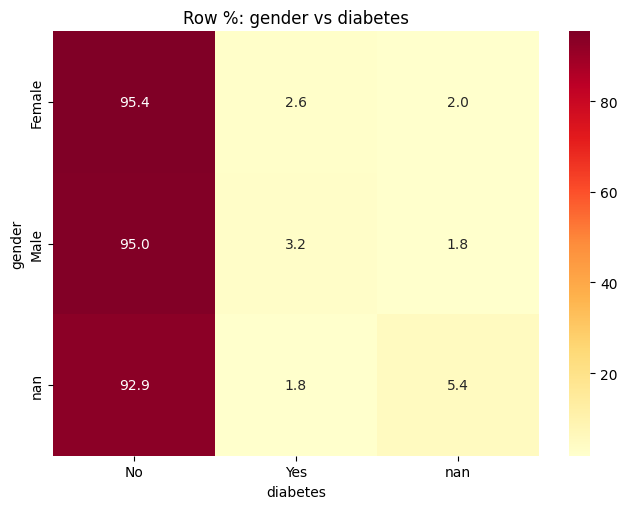

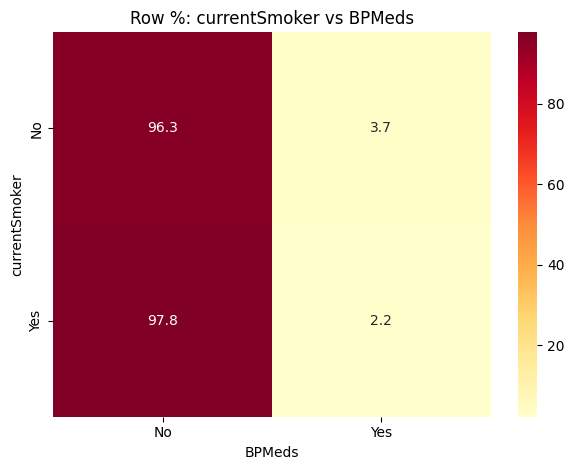

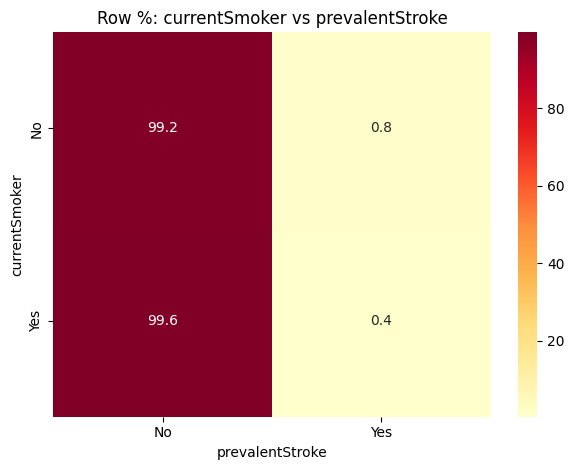

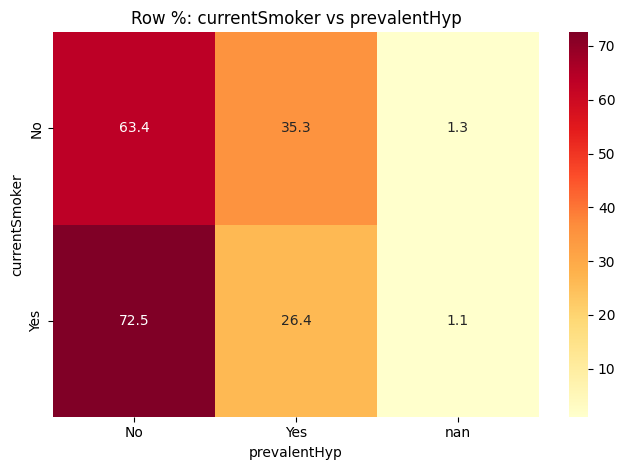

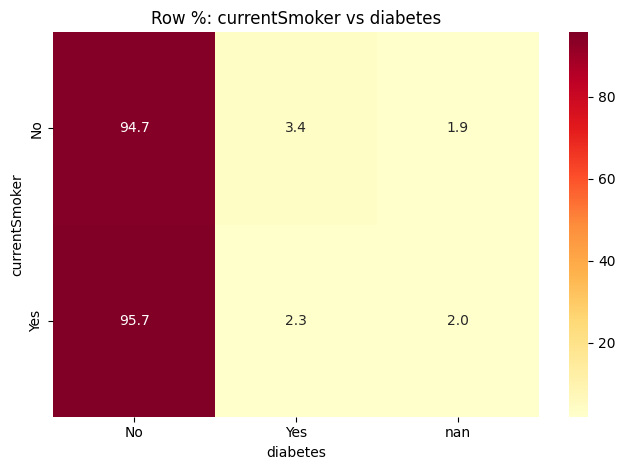

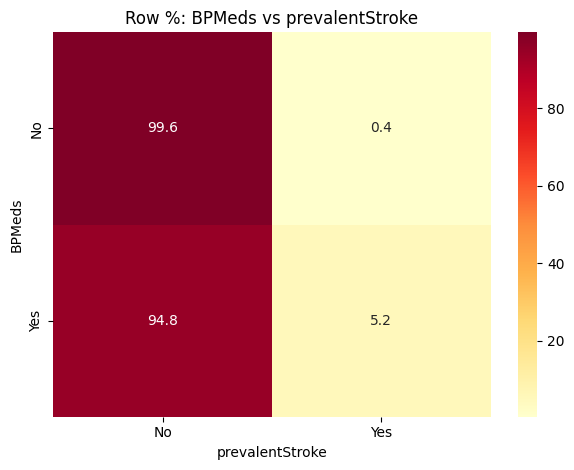

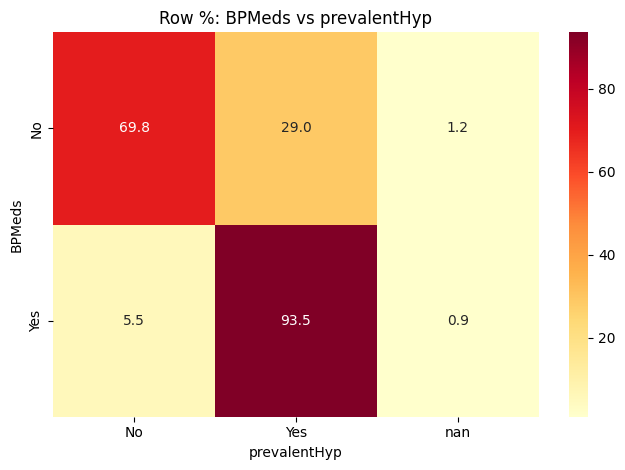

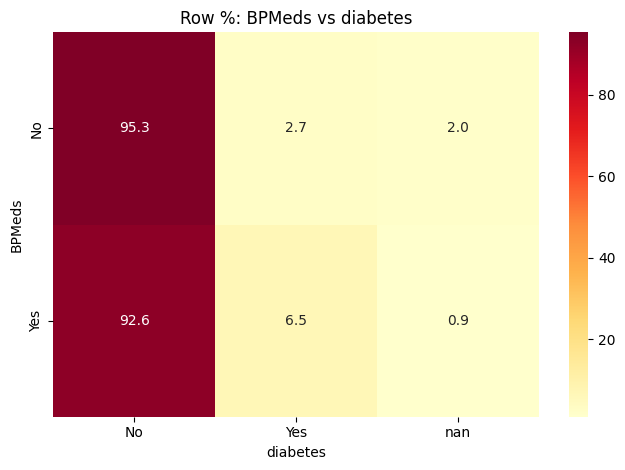

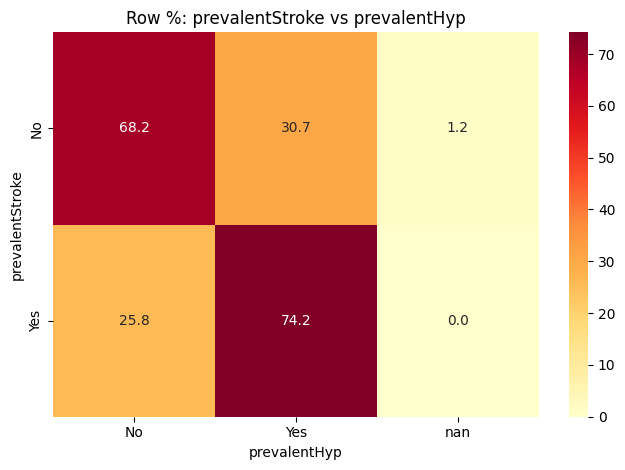

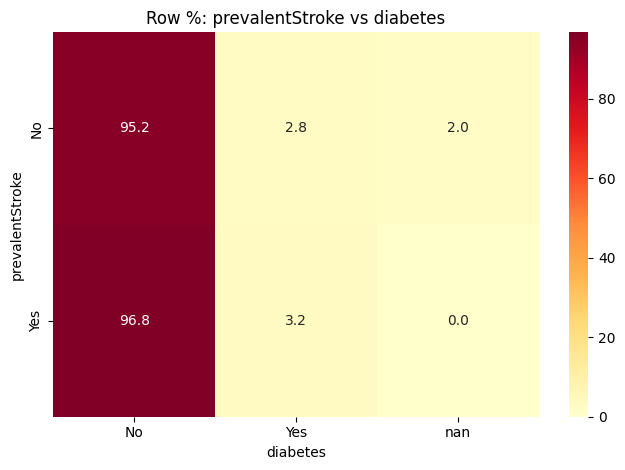

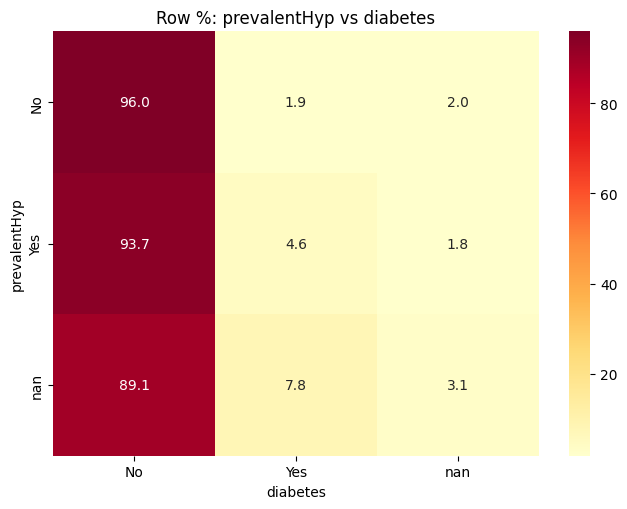

In [205]:
# Pairwise cross-tabs for categorical variables
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

# Use the same categorical_cols as above
cat_cols = ['gender','currentSmoker','BPMeds','prevalentStroke','prevalentHyp','diabetes']

#  Row-normalized percentage heatmaps
for a, b in combinations(cat_cols, 2):
    ct = pd.crosstab(df[a], df[b], normalize='index', dropna=False) * 100
    plt.figure(figsize=(5 + 0.6*ct.shape[1], 4 + 0.4*ct.shape[0]))
    sns.heatmap(ct, annot=True, fmt='.1f', cmap='YlOrRd')
    plt.title(f"Row %: {a} vs {b}")
    plt.xlabel(b)
    plt.ylabel(a)
    plt.tight_layout()
    plt.show()

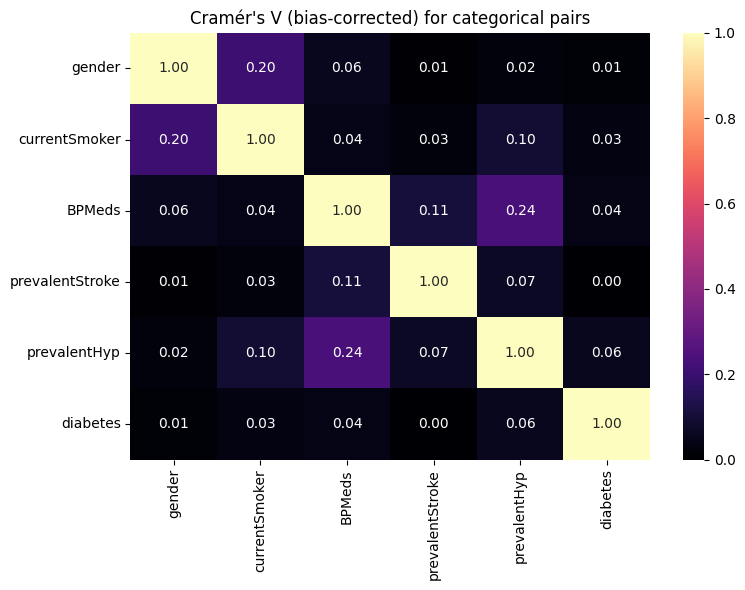

{'high_association_pairs': []}


In [206]:
# Cramér's V association matrix for categorical variables
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# Prefer previously defined categorical_cols; fall back to cat_cols list above
try:
    cat_cols = categorical_cols  # from earlier cell
except NameError:
    cat_cols = ['gender','currentSmoker','BPMeds','prevalentStroke','prevalentHyp','diabetes']

# Ensure categories are treated as strings (avoid mixed types/booleans)
df_cat = df[cat_cols].copy()
for c in df_cat.columns:
    df_cat[c] = df_cat[c].astype(str)

n = len(cat_cols)
cramers = pd.DataFrame(np.ones((n, n)), index=cat_cols, columns=cat_cols)

for i, a in enumerate(cat_cols):
    for j, b in enumerate(cat_cols):
        if j <= i:
            continue  # will mirror later
        # Build contingency table (exclude NaNs)
        ct = pd.crosstab(df_cat[a], df_cat[b])
        if ct.size == 0:
            v = np.nan
        else:
            chi2, p, dof, expected = chi2_contingency(ct, correction=False)
            n_obs = ct.to_numpy().sum()
            phi2 = chi2 / max(n_obs, 1)
            r, k = ct.shape
            # Bias-corrected Cramér's V (Bergsma, 2013)
            phi2corr = max(0, phi2 - (k-1)*(r-1)/(max(n_obs-1, 1)))
            rcorr = r - (r-1)**2 / max(n_obs-1, 1)
            kcorr = k - (k-1)**2 / max(n_obs-1, 1)
            denom = max(min(kcorr-1, rcorr-1), 1e-12)
            v = np.sqrt(phi2corr / denom)
        cramers.loc[a, b] = v
        cramers.loc[b, a] = v

plt.figure(figsize=(8, 6))
sns.heatmap(cramers, annot=True, fmt='.2f', cmap='magma', vmin=0, vmax=1)
plt.title("Cramér's V (bias-corrected) for categorical pairs")
plt.tight_layout()
plt.show()

threshold = 0.8
high_pairs = []
for i in range(n):
    for j in range(i+1, n):
        v = cramers.iat[i, j]
        if pd.notna(v) and v >= threshold:
            high_pairs.append((cat_cols[i], cat_cols[j], float(v)))
print({"high_association_pairs": high_pairs})

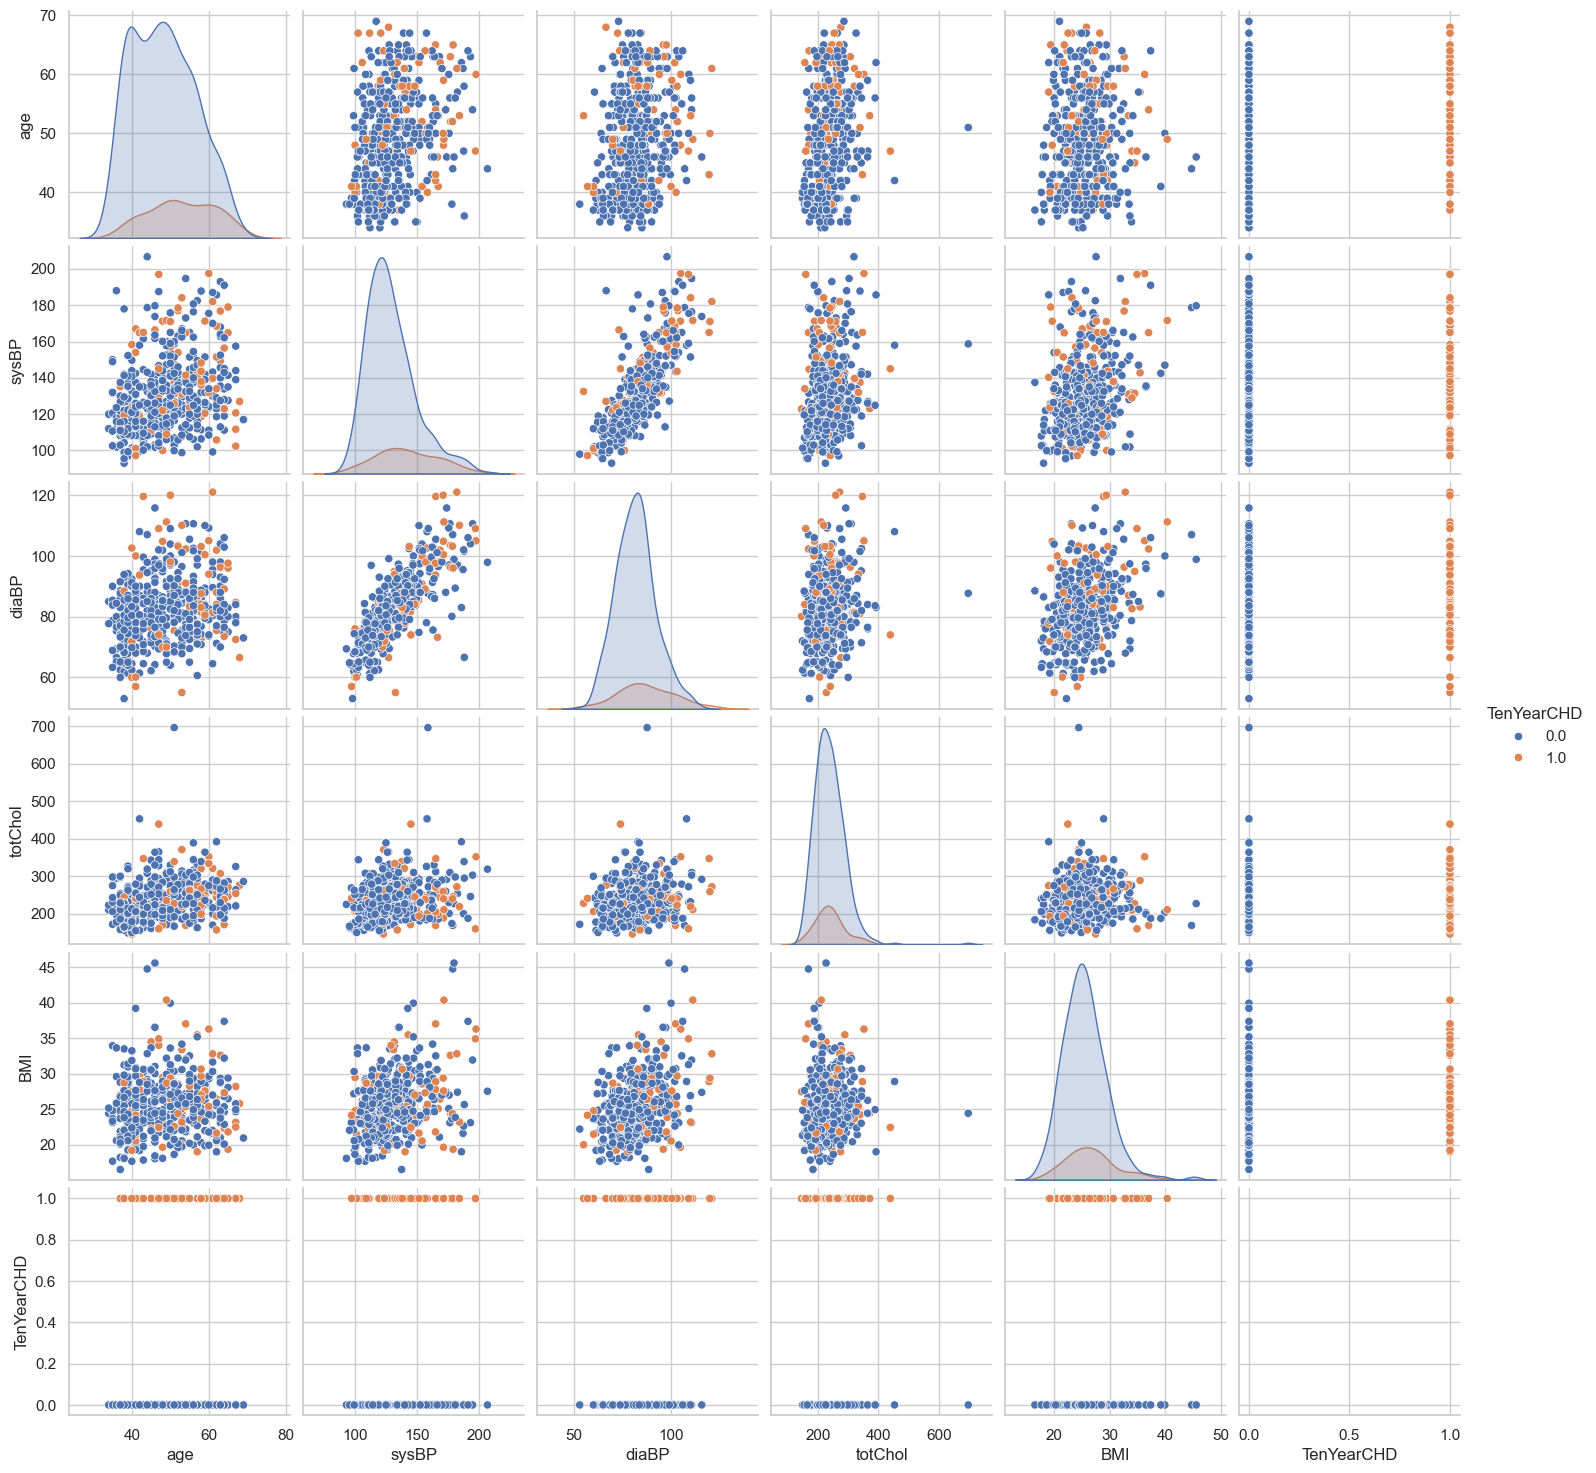

In [105]:
import seaborn as sns

subset = ['age','sysBP','diaBP','totChol','BMI','TenYearCHD']
sns.pairplot(df.sample(500), vars=subset, hue="TenYearCHD")

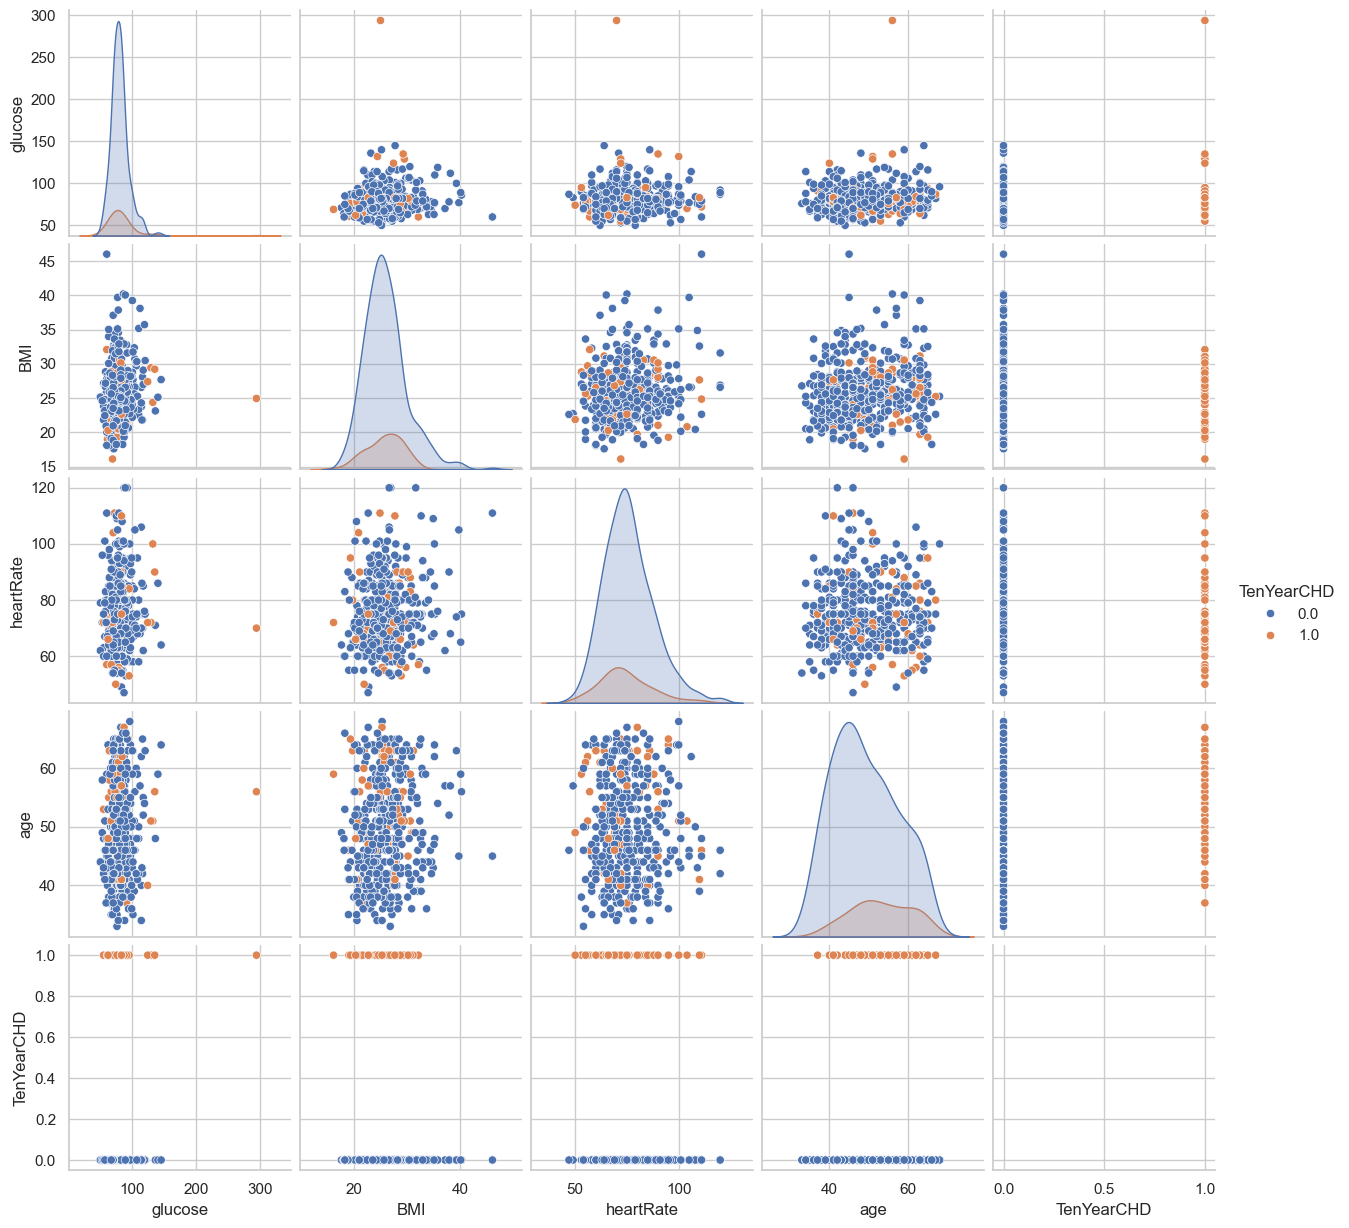

In [106]:
subset = ['glucose','BMI','heartRate','age','TenYearCHD']
sns.pairplot(df.sample(500), vars=subset, hue="TenYearCHD")

# Preprocessing

In [6]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

df_step = df.copy()

# --- Ensure pulsePressure exists and is consistent ---
if "pulsePressure" not in df_step.columns:
    if {"sysBP","diaBP"}.issubset(df_step.columns):
        df_step["pulsePressure"] = df_step["sysBP"] - df_step["diaBP"]
    else:
        raise ValueError("Need sysBP and diaBP to create pulsePressure.")

# Fix impossible pulse pressures (clip negatives)
df_step["pulsePressure"] = df_step["pulsePressure"].clip(lower=0)

# --- Choose which columns to drop ---
to_drop = []
if "diaBP" in df_step.columns:      # drop redundant BP
    to_drop.append("diaBP")
if "education" in df_step.columns:  # drop education
    to_drop.append("education")

df_step = df_step.drop(columns=to_drop)
print("Dropped columns (redundancy/unwanted):", to_drop)

# --- Check collinearity (VIF) ---
vif_features = ["age","sysBP","pulsePressure","BMI","totChol","glucose","heartRate","cigsPerDay"]
existing = [c for c in vif_features if c in df_step.columns]
X_vif = add_constant(df_step[existing].dropna())
vif_table = pd.DataFrame({
    "feature": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
}).sort_values("VIF", ascending=False)

print("\nVIF after dropping diaBP + education:")
print(vif_table.to_string(index=False))

# --- Show final column list ---
print("\nColumns kept (post-redundancy step):")
print(df_step.columns.tolist())
print("Shape now:", df_step.shape)

Dropped columns (redundancy/unwanted): ['diaBP', 'education']

VIF after dropping diaBP + education:
      feature        VIF
        const 127.432383
        sysBP   4.371927
pulsePressure   4.021398
          age   1.271637
          BMI   1.186293
      totChol   1.090233
    heartRate   1.053975
   cigsPerDay   1.048098
      glucose   1.029404

Columns kept (post-redundancy step):
['gender', 'age', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP', 'BMI', 'heartRate', 'glucose', 'TenYearCHD', 'pulsePressure']
Shape now: (11000, 15)


In [7]:
from sklearn.impute import SimpleImputer

# Copy working dataset (with diaBP already dropped earlier)
df_mv = df_step.copy()

# --- 1. Drop missing target rows (already discussed) ---
df_mv = df_mv.dropna(subset=["TenYearCHD"])

# --- 2. Identify numeric & categorical ---
num_cols = df_mv.select_dtypes(include=[np.number]).columns.drop("TenYearCHD", errors="ignore").tolist()
cat_cols = df_mv.select_dtypes(include=["object","category","bool"]).columns.tolist()

print("Numeric cols:", num_cols)
print("Categorical cols:", cat_cols)

# --- 3. Impute numeric (median) ---
num_imputer = SimpleImputer(strategy="median")
df_mv[num_cols] = num_imputer.fit_transform(df_mv[num_cols])

# --- 4. Impute categorical (mode) ---
cat_imputer = SimpleImputer(strategy="most_frequent")
df_mv[cat_cols] = cat_imputer.fit_transform(df_mv[cat_cols])

# --- 5. Verify missing values fixed ---
print("\nMissing values after imputation:\n", df_mv.isna().sum())
print("\nShape now:", df_mv.shape)

Numeric cols: ['age', 'cigsPerDay', 'totChol', 'sysBP', 'BMI', 'heartRate', 'glucose', 'pulsePressure']
Categorical cols: ['gender', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes']

Missing values after imputation:
 gender             0
age                0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
pulsePressure      0
dtype: int64

Shape now: (10639, 15)


In [8]:
df_ol = df_mv.copy()  # after imputation step

# Define capping thresholds
caps = {
    "totChol": (100, 400),         # normal: 125–200, cap extreme high
    "glucose": (40, 250),          # normal: 70–140, cap >250
    "pulsePressure": (0, 120),     # physiologic ~40, rarely >100
    "sysBP": (80, 250),            # >250 = hypertensive crisis
    "BMI": (15, 45)                # >45 = extreme obesity
}

# Apply capping
capped_counts = {}
for col, (low, high) in caps.items():
    before = df_ol[col].copy()
    df_ol[col] = df_ol[col].clip(lower=low, upper=high)
    capped_counts[col] = (before != df_ol[col]).sum()

# Show results
print("Outlier handling complete.")
print("Number of capped values per column:")
for col, n in capped_counts.items():
    print(f"  {col}: {n}")

print("\nSummary stats after capping:\n", df_ol[list(caps.keys())].describe().T)

Outlier handling complete.
Number of capped values per column:
  totChol: 25
  glucose: 52
  pulsePressure: 16
  sysBP: 3
  BMI: 12

Summary stats after capping:
                  count        mean        std     min     25%     50%     75%  \
totChol        10639.0  236.514428  43.882108  107.00  205.00  234.00  263.00   
glucose        10639.0   81.767553  21.001003   40.00   71.00   78.00   87.00   
pulsePressure  10639.0   49.433951  14.772941    0.00   39.90   46.90   55.80   
sysBP          10639.0  132.525839  21.947773   83.50  117.00  128.50  144.00   
BMI            10639.0   25.824730   4.085449   15.54   23.08   25.42   28.06   

                 max  
totChol        400.0  
glucose        250.0  
pulsePressure  120.0  
sysBP          250.0  
BMI             45.0  


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# --------------------------------------------------
# Start from your last cleaned frame after outliers:
#   df_ol  (has TenYearCHD with no NaNs, diaBP dropped, caps applied)
# --------------------------------------------------

# Identify column types
target = "TenYearCHD"
X_full = df_ol.drop(columns=[target])
y_full = df_ol[target].astype(int)  # ensure 0/1 int

# Explicitly declare categorical columns (object/category/bool)
cat_cols = X_full.select_dtypes(include=["object","category","bool"]).columns.tolist()
# If any of these are accidentally numeric strings, cast them:
# X_full[cat_cols] = X_full[cat_cols].astype("category")

# Numeric columns are the rest
num_cols = X_full.columns.difference(cat_cols).tolist()

print("Categorical:", cat_cols)
print("Numeric:", num_cols)

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, stratify=y_full, random_state=42
)

# Build transformers
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", drop="if_binary", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop"
)

# Fit the preprocessor on train only (avoids leakage)
preprocessor.fit(X_train)

# Transform to arrays
X_train_pre = preprocessor.transform(X_train)
X_test_pre  = preprocessor.transform(X_test)

print("Shapes →  X_train_pre:", X_train_pre.shape, " | X_test_pre:", X_test_pre.shape)

# Inspect final feature names (handy for interpretability / later modeling)
# Note: get_feature_names_out available in sklearn >= 1.0
feat_names = preprocessor.get_feature_names_out()
print("Final feature names:", feat_names.tolist())

Categorical: ['gender', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes']
Numeric: ['BMI', 'age', 'cigsPerDay', 'glucose', 'heartRate', 'pulsePressure', 'sysBP', 'totChol']
Shapes →  X_train_pre: (8511, 14)  | X_test_pre: (2128, 14)
Final feature names: ['num__BMI', 'num__age', 'num__cigsPerDay', 'num__glucose', 'num__heartRate', 'num__pulsePressure', 'num__sysBP', 'num__totChol', 'cat__gender_Male', 'cat__currentSmoker_Yes', 'cat__BPMeds_Yes', 'cat__prevalentStroke_Yes', 'cat__prevalentHyp_Yes', 'cat__diabetes_Yes']


In [13]:
# No missing values post-transform?
print("Any NaNs in X_train_pre? ", np.isnan(X_train_pre).sum())
print("Any NaNs in X_test_pre?  ", np.isnan(X_test_pre).sum())

# Class balance preserved via stratify
print("Train positive rate:", y_train.mean())
print("Test  positive rate:", y_test.mean())

Any NaNs in X_train_pre?  0
Any NaNs in X_test_pre?   0
Train positive rate: 0.1534484784396663
Test  positive rate: 0.1536654135338346


In [14]:
import joblib
joblib.dump(preprocessor, "preprocessor.joblib")
joblib.dump((X_train, X_test, y_train, y_test), "splits.joblib")

['splits.joblib']

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

logit = LogisticRegression(class_weight="balanced", max_iter=1000)
logit.fit(X_train_pre, y_train)

y_pred  = logit.predict(X_test_pre)
y_proba = logit.predict_proba(X_test_pre)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred, digits=3))

ROC AUC: 0.7310872145444174
              precision    recall  f1-score   support

           0      0.922     0.664     0.772      1801
           1      0.272     0.691     0.390       327

    accuracy                          0.668      2128
   macro avg      0.597     0.678     0.581      2128
weighted avg      0.822     0.668     0.713      2128



In [17]:
import joblib
import numpy as np
import pandas as pd

# Load the full pipeline you saved (preprocessor + RandomForest)
model = joblib.load("heart_rf_pipeline.pkl")

# Peek at the inner pieces (optional)
print(type(model))
print(model.named_steps.keys())  # e.g., dict_keys(['preprocessor', 'classifier'])

# What feature names does the preprocessor expect?
expected_cols = model.named_steps["preprocessor"].feature_names_in_.tolist()
print("Expected input columns:", expected_cols)

<class 'sklearn.pipeline.Pipeline'>
dict_keys(['preprocessor', 'classifier'])
Expected input columns: ['gender', 'age', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP', 'BMI', 'heartRate', 'glucose', 'pulsePressure']


In [18]:
# Example input (fill with realistic values)
sample = {
    "gender": "Male",            # 'Male'/'Female'
    "age": 58,                   # numeric
    "currentSmoker": "Yes",      # 'Yes'/'No'
    "cigsPerDay": 12,
    "BPMeds": "No",
    "prevalentStroke": "No",
    "prevalentHyp": "Yes",
    "diabetes": "No",
    "totChol": 240,
    "sysBP": 138,
    "BMI": 28.5,
    "heartRate": 78,
    "glucose": 95,
    "pulsePressure": 50,         # sysBP - diaBP (you kept this feature)
    # 'education' dropped earlier, 'diaBP' dropped earlier
}

# Ensure the DataFrame has exactly the expected columns (order not required)
# If your dict misses a column, we’ll add it with NaN so the pipeline can impute.
df_in = pd.DataFrame([sample])
for col in expected_cols:
    if col not in df_in.columns:
        df_in[col] = np.nan
df_in = df_in[expected_cols]

# Predict class and probability
pred = model.predict(df_in)[0]             # 0 or 1
proba = model.predict_proba(df_in)[0, 1]   # P(CHD=1)

print({"prediction": int(pred), "probability": float(proba)})

{'prediction': 0, 'probability': 0.14}


In [127]:
threshold = 0.35

proba = model.predict_proba(df_in)[:, 1]
pred_thresh = (proba >= threshold).astype(int)

print("Prob:", float(proba[0]), " Pred@thr=0.35:", int(pred_thresh[0]))

Prob: 0.14  Pred@thr=0.35: 0
